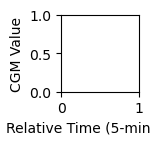

In [1]:
import matplotlib.pyplot as plt
from IPython.display import clear_output
plt.figure(figsize=(1, 1))
plt.xlabel('Relative Time (5-min units)')
plt.ylabel('CGM Value')
plt.show()

In [2]:
import os
import pandas as pd
import math
import random
import numpy as np
import torch

from torch.utils.data import Dataset
from collections import defaultdict
from tqdm import tqdm

from dataset import CGMDataset
from model import CGMPredictor
torch._dynamo.config.suppress_errors = True

C:\Users\daomi\anaconda3\Lib\site-packages\torch\utils\_pytree.py:185: FutureWarning: optree is installed but the version is too old to support PyTorch Dynamo in C++ pytree. C++ pytree support is disabled. Please consider upgrading optree using `python3 -m pip install --upgrade 'optree>=0.13.0'`.
  warnings.warn(


In [3]:
dataset = CGMDataset(file="./Datasets", max_len=512 * 10, split="val", augment=False, max_deviation = 99999, max_range = 1.2)

Users loaded: 100%|████████████████████████████████████████████████████████████████| 1673/1673 [00:52<00:00, 31.81it/s]


In [4]:


def predict(batch):
    with torch.no_grad():
        cgm = batch['cgm'].unsqueeze(0).to(device)
        basal = batch['basal'].unsqueeze(0).to(device)
        bolus = batch['bolus'].unsqueeze(0).to(device)
        cgm_time = batch['cgm_time'].unsqueeze(0).to(device)
        basal_time = batch['basal_time'].unsqueeze(0).to(device)
        bolus_time = batch['bolus_time'].unsqueeze(0).to(device)
        target_cgm = batch['target_cgm'].unsqueeze(0).to(device)
        target_time = batch['target_time'].unsqueeze(0).to(device)
        pred_time = batch['pred_time'].unsqueeze(0).to(device)
        
        return model(cgm, basal, bolus, cgm_time, basal_time, bolus_time, target_time, pred_time)[0].to('cpu').detach()

def plot_sample(dataset, time_fraction=1.0):


    # Extract
    raw_cgm = sample['raw_cgm']
    raw_cgm_time = sample['raw_cgm_time']
    
    input_cgm = sample['cgm']
    input_cgm_time = sample['cgm_time']
    
    target_cgm = sample['target_cgm']
    target_time = sample['target_time']

    bolus = sample['bolus']
    bolus_time = sample['bolus_time']

    # Limit based on time_fraction
    t_min = raw_cgm_time.min()
    t_max = raw_cgm_time.max()
    t_cutoff = t_max - time_fraction * (t_max - t_min)

    mask_raw = (t_cutoff <= raw_cgm_time)
    mask_input = (t_cutoff <= input_cgm_time)
    mask_target = (t_cutoff <= target_time)
    mask_bolus = (t_cutoff <= bolus_time)

    # Plot
    plt.figure(figsize=(12, 6))
    plt.plot(raw_cgm_time[mask_raw].numpy(), raw_cgm[mask_raw].numpy(), label='Raw CGM', color='black')


    plt.scatter(bolus_time[mask_bolus].numpy(), bolus[mask_bolus].numpy() * 10,
                color='blue', s=5, label='Bolus', zorder=3)

    
    v = predict(sample)
    pred_times = target_time[mask_target].numpy()
    pred_values = v[mask_target].numpy()

    plt.plot(pred_times, pred_values, label='Predicted CGM', color='green')
    plt.scatter(pred_times, pred_values, color='green', s=12, label='Predicted CGM', zorder=4)
    
    # Draw lines 12 units to the left
    for x, y, d in zip(pred_times, pred_values, sample['pred_time']):
        plt.plot([x - d, x], [y, y], color='green', linewidth=0.8, alpha=0.6, zorder=3)

    plt.xlabel('Relative Time (5-min units)')
    plt.ylabel('CGM Value')
    plt.title(f'CGM Sampling Visualization (showing {100*time_fraction:.0f}% of timeline)')
    plt.legend()
    plt.grid(True)
    plt.show()


In [6]:
device = 'cpu'
model = CGMPredictor(
    n_embd=8*48,
    n_head=8,
    n_layer=3,
    dropout=0.0
).to(device)


model = torch.compile(model)
model.eval()



OptimizedModule(
  (_orig_mod): CGMPredictor(
    (basal_embd): Encoding(
      (encoding): Sequential(
        (0): Linear(in_features=11, out_features=1536, bias=True)
        (1): ReLU()
        (2): Linear(in_features=1536, out_features=384, bias=True)
        (3): ReLU()
        (4): LayerNorm((384,), eps=1e-05, elementwise_affine=True)
      )
    )
    (bolus_embd): Encoding(
      (encoding): Sequential(
        (0): Linear(in_features=11, out_features=1536, bias=True)
        (1): ReLU()
        (2): Linear(in_features=1536, out_features=384, bias=True)
        (3): ReLU()
        (4): LayerNorm((384,), eps=1e-05, elementwise_affine=True)
      )
    )
    (cgm_embd): Encoding(
      (encoding): Sequential(
        (0): Linear(in_features=11, out_features=1536, bias=True)
        (1): ReLU()
        (2): Linear(in_features=1536, out_features=384, bias=True)
        (3): ReLU()
        (4): LayerNorm((384,), eps=1e-05, elementwise_affine=True)
      )
    )
    (blocks): Module

In [ ]:
sample = dataset[0]
sample['target_time'] = torch.concat([sample['target_time'][:-18]])
sample['pred_time'] = torch.tensor([9]*len(sample['target_time']))
sample['target_time'], indices = torch.sort(sample['target_time'])

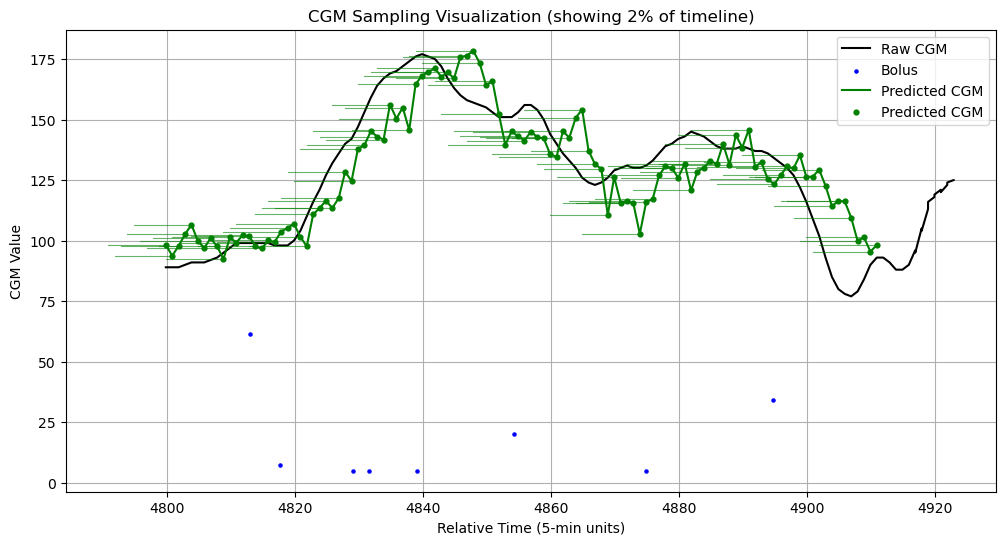

In [109]:

model.load_state_dict(torch.load(f'./model_iter_19000.pth', map_location=torch.device(device)))
plot_sample(dataset, time_fraction=0.025)

W0609 18:25:26.412000 2101475 site-packages/torch/utils/_sympy/interp.py:176] [0/2] failed while executing pow_by_natural([VR[12, int_oo], VR[-1, -1]])
W0609 18:25:26.417000 2101475 site-packages/torch/utils/_sympy/interp.py:176] [0/2] failed while executing pow_by_natural([VR[12, int_oo], VR[-1, -1]])
W0609 18:25:26.420000 2101475 site-packages/torch/utils/_sympy/interp.py:176] [0/2] failed while executing pow_by_natural([VR[12, int_oo], VR[-1, -1]])
W0609 18:25:26.557000 2101475 site-packages/torch/utils/_sympy/interp.py:176] [0/2] failed while executing pow_by_natural([VR[12, int_oo], VR[-1, -1]])
W0609 18:25:26.561000 2101475 site-packages/torch/utils/_sympy/interp.py:176] [0/2] failed while executing pow_by_natural([VR[12, int_oo], VR[-1, -1]])
W0609 18:25:26.564000 2101475 site-packages/torch/utils/_sympy/interp.py:176] [0/2] failed while executing pow_by_natural([VR[12, int_oo], VR[-1, -1]])
W0609 18:25:26.663000 2101475 site-packages/torch/utils/_sympy/interp.py:176] [0/2] fail

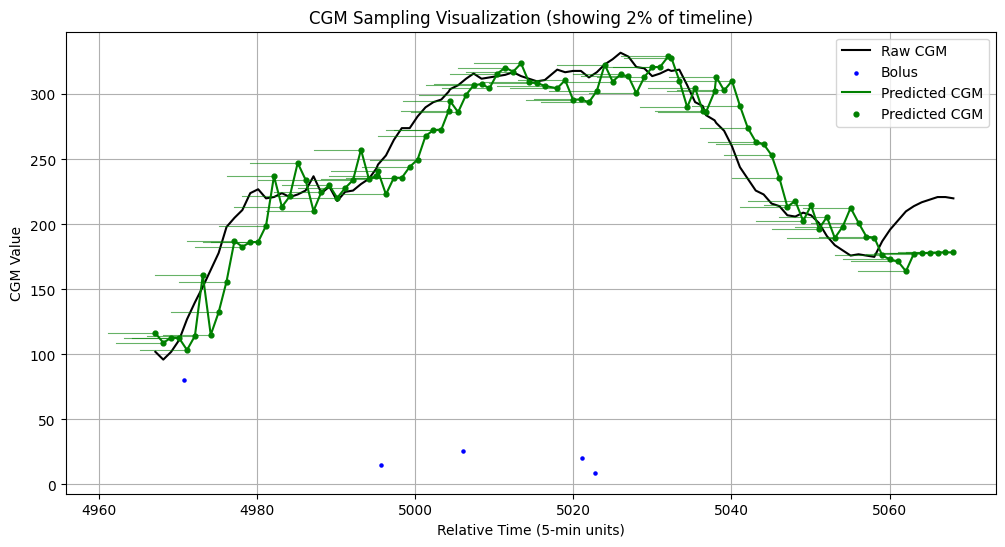

In [51]:
#for i in range(40, 40+1):
model.load_state_dict(torch.load(f'./model_iter_19000.pth', map_location=torch.device(device)))
plot_sample(dataset, time_fraction=0.02)
clear_output(wait=True)

In [191]:
torch.Tensor([[1,2,3,4],[1,2,3,2]]).mean(dim=0)

tensor([1., 2., 3., 3.])

In [ ]:
all_cgm_vals = []
all_basal_vals = []
all_bolus_vals = []

for user_data in tqdm(dataset.data, desc="Processing users"):
    cgm_df = user_data["cgm"]
    basal_df = user_data["basal"]
    bolus_df = user_data["bolus"]

    if 'cgm' in cgm_df.columns:
        all_cgm_vals.extend(cgm_df['cgm'].dropna().values)

    if 'basal_rate' in basal_df.columns:
        all_basal_vals.extend(basal_df['basal_rate'].dropna().values)

    if 'bolus' in bolus_df.columns:
        all_bolus_vals.extend(bolus_df['bolus'].dropna().values)

def describe(name, arr):
    if len(arr) == 0:
        print(f"{name}: No data.")
        return
    arr = np.array(arr)
    print(f"\n{name} Stats:")
    print(f"  Count   : {len(arr)}")
    print(f"  Mean    : {np.mean(arr):.4f}")
    print(f"  Median  : {np.median(arr):.4f}")
    print(f"  Std Dev : {np.std(arr):.4f}")
    print(f"  Min     : {np.min(arr):.4f}")
    print(f"  Max     : {np.max(arr):.4f}")
    print(f"  25%     : {np.quantile(arr, 0.25):.4f}")
    print(f"  75%     : {np.quantile(arr, 0.75):.4f}")
    print(f"  95%     : {np.quantile(arr, 0.95):.4f}")

# Output results
describe("CGM", all_cgm_vals)
describe("Basal", all_basal_vals)
describe("Bolus", all_bolus_vals)

Processing users:  37%|██████████████████████▌                                      | 496/1338 [00:17<00:40, 20.91it/s]